# Studying Crime Rate in New York City
## NYU-CUSP Principles of Urban Informatics 2017 Final
### Praveen Ashok Kumar (pak348@nyu.edu)

### **Motivation:**

The study of NYC crime is of broad interest in the Urban Science scene, and NYPD has provided statistics on the crime (by precinct) for several years. This is an important resource to understand and analyze urban crime. There are obvious connections between crime and wealth, which relate both to access to precious goods (opportunity), and to how easy it is to commit a crime (the neighborhood safety, or perceived safety). [It has been suggested](https://journalistsresource.org/studies/government/criminal-justice/unemployment-property-crime-burglary) that unemployment correlates strongly with burglary for example, due to both opportunity and motivation. In addition there are [several pieces of research](https://www.citylab.com/solutions/2016/04/vacant-lots-green-space-crime-research-statistics/476040/) that indicate that access to green spaces affects crime.

In this final we explore and model NYC crime:

- The first part is an exploratory analysis of the crime time series for the seven major felonies 2000-2016 (temporal domain).

- The second part attempts to relate socioeconomic features to individual crime rates by area (spatial domain).

- Lastly,we aggregate the socioeconomic features that I indicated at the precinct level: percentage of unemployment and median income, that natively come at the census tract level from the census bureau API, and green area, for which we use the NYC parks shapefile.

## Key Varriables:

### Crime Rate (7-Major Types)
### Wealth
### Unemployment Rate
### Green Spaces


In [1]:
# Importing the necessary Libraries
from __future__ import print_function, division
import os
import json
import numpy as np
import datetime as dt
import pandas as pd
import geopandas as gpd
from geopandas.tools import overlay
import ast
import pylab as pl
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns;
import shapely
from shapely import geometry
from fiona.crs import from_epsg
from sklearn import preprocessing, cluster, ensemble, linear_model

urlc = 'https://raw.githubusercontent.com/praveenashokkumar/PUI2017_pak348/60be87f32523735551808eb396b7695a36d68757/HW9_pak348/choroplethNYC.py'
os.system('wget ' + urlc)

import choroplethNYC as cp

try: 
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib
%pylab inline

s = json.load( open(os.getenv('PUIDATA') + '/fbb_matplotlibrc.json') )
pl.rcParams.update(s)
if os.getenv("PUIDATA") is None:
   print ("$PUIDATA to point to set PUIdata dir")


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  mplDeprecation)


In [2]:
# Adapted from https://github.com/fedhere/PUI2017_fb55/blob/9d1ff5d8d6c09da9be9cc65f562395cc405eec0c/HW7_fb55/SQL_query_solution.ipynb

SQL_SOURCE = 'https://fb55.carto.com:443/api/v2/sql?q='

try:
    #import urllib2
    from urllib2 import HTTPError
    from urllib2 import urlopen
    from urllib import urlencode
    from StringIO import StringIO as StringIO

except ImportError:
    #import urllib
    from urllib.error import HTTPError
    from urllib.request import urlopen, Request
    from urllib.parse import urlencode
    from io import BytesIO as StringIO
    

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    '''queries carto datasets from a given carto account
    Arguments: 
    query - string: a valid sql query string
    format - outlut format  OPTIONAL (default CSV)
    source - a valid sql api endpoint OPTIONAL (default carto fb55 account)
    Returns:
    the return of the sql query AS A STRING
    NOTES:
    designed for the carto API, tested only with CSV return format'''
    
    data = urlencode({'format': format, 'q': query}).encode("utf-8")
    try:
        response = urlopen(source, data)
    except HTTPError as e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return response.read()

In [3]:
#Working Data Directory
PUIdata = os.getenv("PUIDATA")
print (PUIdata)

/home/cusp/pak348/PUIdata


# PEP8 long lilne

In [4]:
test = 1 # If Test = 1 then it runs all downloads
if(test == 1):
    url = 'https://www1.nyc.gov/assets/nypd/downloads/excel/analysis_and_planning/\seven-major-felony-offenses-by-precinct-2000-2016.xls'
    filename = 'seven-major-felony-offenses-by-precinct-2000-2016.xls'
    os.system('wget ' + url)
    os.system('mv ' + filename + 'PUIdata')

# FBB This fails cause you have a missing space: should be ' PUIdata'
# task 1.1 5/10

# 1. Time domain exploratory analysis

## 1.1 obtain historical data for 2000-2016 for all NYC police prec
Obtained the data from NYC.gov it should be an excel file called seven-major-felony-offenses-by-precinct-2000-2016.xls

In [5]:
#Storing the data in a Data Frame that contains all the Crimes Listed Precint-Wise from year 2000 to 2016
df_C = pd.read_excel(PUIdata + '/' + filename, header=1)

In [6]:
df_C.head(8)

,PCT,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,1,MURDER & NON NEGL. MANSLAUGHTER ...,3.0,1.0,2.0,2.0,2.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0
1,NaN,RAPE,12.0,5.0,10.0,11.0,11.0,5.0,4.0,7.0,12.0,4.0,6.0,13.0,10.0,12.0,8.0,7.0,9.0
2,NaN,ROBBERY,252.0,188.0,210.0,164.0,154.0,172.0,119.0,128.0,108.0,106.0,96.0,102.0,81.0,68.0,50.0,79.0,60.0
3,NaN,FELONY ASSAULT,139.0,164.0,147.0,134.0,129.0,121.0,94.0,90.0,83.0,83.0,68.0,94.0,110.0,87.0,76.0,86.0,78.0
4,NaN,BURGLARY,475.0,437.0,297.0,403.0,246.0,293.0,255.0,231.0,189.0,207.0,170.0,155.0,188.0,171.0,145.0,138.0,117.0
5,NaN,GRAND LARCENY,2358.0,2117.0,1896.0,1803.0,1708.0,1624.0,1462.0,1395.0,1258.0,1122.0,1065.0,979.0,985.0,1051.0,896.0,1114.0,1081.0
6,NaN,GRAND LARCENY OF MOTOR VEHICLE ...,199.0,157.0,153.0,132.0,133.0,90.0,78.0,63.0,57.0,54.0,38.0,59.0,41.0,27.0,33.0,21.0,50.0
7,NaN,TOTAL SEVEN MAJOR FELONY OFFENSES,3438.0,3069.0,2715.0,2649.0,2383.0,2305.0,2013.0,1914.0,1708.0,1578.0,1445.0,1402.0,1416.0,1416.0,1208.0,1446.0,1395.0


In [7]:
# Filling NaN values with previous value
df_C = df_C.fillna(method='ffill') 
#df_C["mean"] = df_C.mean(axis=1)

In [8]:
df_C.head(9)

,PCT,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,1,MURDER & NON NEGL. MANSLAUGHTER ...,3.0,1.0,2.0,2.0,2.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1,RAPE,12.0,5.0,10.0,11.0,11.0,5.0,4.0,7.0,12.0,4.0,6.0,13.0,10.0,12.0,8.0,7.0,9.0
2,1,ROBBERY,252.0,188.0,210.0,164.0,154.0,172.0,119.0,128.0,108.0,106.0,96.0,102.0,81.0,68.0,50.0,79.0,60.0
3,1,FELONY ASSAULT,139.0,164.0,147.0,134.0,129.0,121.0,94.0,90.0,83.0,83.0,68.0,94.0,110.0,87.0,76.0,86.0,78.0
4,1,BURGLARY,475.0,437.0,297.0,403.0,246.0,293.0,255.0,231.0,189.0,207.0,170.0,155.0,188.0,171.0,145.0,138.0,117.0
5,1,GRAND LARCENY,2358.0,2117.0,1896.0,1803.0,1708.0,1624.0,1462.0,1395.0,1258.0,1122.0,1065.0,979.0,985.0,1051.0,896.0,1114.0,1081.0
6,1,GRAND LARCENY OF MOTOR VEHICLE ...,199.0,157.0,153.0,132.0,133.0,90.0,78.0,63.0,57.0,54.0,38.0,59.0,41.0,27.0,33.0,21.0,50.0
7,1,TOTAL SEVEN MAJOR FELONY OFFENSES,3438.0,3069.0,2715.0,2649.0,2383.0,2305.0,2013.0,1914.0,1708.0,1578.0,1445.0,1402.0,1416.0,1416.0,1208.0,1446.0,1395.0
8,5,MURDER & NON NEGL. MANSLAUGHTER ...,4.0,3.0,0.0,3.0,1.0,4.0,2.0,2.0,2.0,1.0,1.0,0.0,3.0,3.0,2.0,1.0,0.0


In [9]:
df_C.tail(9)

,PCT,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
627,STATISTICAL NOTES,TOTAL SEVEN MAJOR FELONY OFFENSES,636.0,514.0,495.0,467.0,464.0,570.0,475.0,496.0,515.0,414.0,371.0,413.0,396.0,378.0,413.0,379.0,509.0
628,1. 2000-2005 Data Source-Historical Comfinal d...,TOTAL SEVEN MAJOR FELONY OFFENSES,636.0,514.0,495.0,467.0,464.0,570.0,475.0,496.0,515.0,414.0,371.0,413.0,396.0,378.0,413.0,379.0,509.0
629,2. 2006-2016 Data Source-CDW Omniform System a...,TOTAL SEVEN MAJOR FELONY OFFENSES,636.0,514.0,495.0,467.0,464.0,570.0,475.0,496.0,515.0,414.0,371.0,413.0,396.0,378.0,413.0,379.0,509.0
630,3. Murder & Non-Negligent Manslaughter data so...,TOTAL SEVEN MAJOR FELONY OFFENSES,636.0,514.0,495.0,467.0,464.0,570.0,475.0,496.0,515.0,414.0,371.0,413.0,396.0,378.0,413.0,379.0,509.0
631,4. 2000-2009 data as of 12/8/2010. 2010 data ...,TOTAL SEVEN MAJOR FELONY OFFENSES,636.0,514.0,495.0,467.0,464.0,570.0,475.0,496.0,515.0,414.0,371.0,413.0,396.0,378.0,413.0,379.0,509.0
632,4. 2000-2009 data as of 12/8/2010. 2010 data ...,TOTAL SEVEN MAJOR FELONY OFFENSES,636.0,514.0,495.0,467.0,464.0,570.0,475.0,496.0,515.0,414.0,371.0,413.0,396.0,378.0,413.0,379.0,509.0
633,"5. On Sept. 28, 2012, there was a re-alignment...",TOTAL SEVEN MAJOR FELONY OFFENSES,636.0,514.0,495.0,467.0,464.0,570.0,475.0,496.0,515.0,414.0,371.0,413.0,396.0,378.0,413.0,379.0,509.0
634,6. The 121 pct was created on 7-1-2013 from pa...,TOTAL SEVEN MAJOR FELONY OFFENSES,636.0,514.0,495.0,467.0,464.0,570.0,475.0,496.0,515.0,414.0,371.0,413.0,396.0,378.0,413.0,379.0,509.0
635,7. As of 1-1-2014 complaints occurring within ...,TOTAL SEVEN MAJOR FELONY OFFENSES,636.0,514.0,495.0,467.0,464.0,570.0,475.0,496.0,515.0,414.0,371.0,413.0,396.0,378.0,413.0,379.0,509.0


In [10]:
df_C.describe()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
count,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000,636.000000
mean,630.188679,554.213836,527.141509,499.028302,483.877358,466.738994,441.257862,417.588050,408.408805,367.578616,361.676101,368.927673,386.603774,361.996855,343.396226,338.764151,329.465409
std,886.138426,790.743142,739.370608,697.085017,675.478938,638.157402,602.084727,571.483049,556.479626,505.148518,495.912139,504.452529,533.872234,509.611397,489.177964,482.938947,473.514493
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,75.500000,70.500000,74.500000,61.750000,56.750000,54.000000,43.500000,43.750000,42.250000,36.000000,35.000000,34.000000,33.000000,29.750000,28.750000,29.750000,28.000000
50%,361.000000,315.500000,305.500000,277.500000,279.000000,275.500000,254.000000,228.000000,222.500000,208.000000,196.500000,200.500000,205.000000,177.000000,169.500000,163.500000,141.500000
75%,648.250000,581.000000,561.500000,524.750000,496.250000,514.250000,475.000000,475.000000,460.000000,414.000000,396.250000,413.000000,435.000000,415.000000,413.000000,379.000000,425.250000
max,6857.000000,6088.000000,5265.000000,5105.000000,4730.000000,4423.000000,4173.000000,3971.000000,3708.000000,3330.000000,3103.000000,3393.000000,3780.000000,3902.000000,3751.000000,3506.000000,3287.000000


# ----------------------------------x-----x-------x--------------------------------------------------------

# task 1 5

## 1.2 Removing outliers (likely wrongly input data)


In the data downloaded for Precint 121 it can be observed that the value of all the crimes are the same and also the overall value is extremely high. Hence, we will drop the values of Crime in Precint 121. 

In [11]:
#Identifying the Anomaly
ano = df_C[df_C.PCT == 121]

In [12]:
ano

,PCT,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
592,121,MURDER & NON NEGL. MANSLAUGHTER ...,2347.0,2048.0,1968.0,1738.0,1785.0,1812.0,1722.0,1706.0,1692.0,1505.0,1547.0,1630.0,1873.0,1.0,4.0,0.0,9.0
593,121,RAPE,2347.0,2048.0,1968.0,1738.0,1785.0,1812.0,1722.0,1706.0,1692.0,1505.0,1547.0,1630.0,1873.0,9.0,12.0,13.0,19.0
594,121,ROBBERY,2347.0,2048.0,1968.0,1738.0,1785.0,1812.0,1722.0,1706.0,1692.0,1505.0,1547.0,1630.0,1873.0,99.0,151.0,138.0,120.0
595,121,FELONY ASSAULT,2347.0,2048.0,1968.0,1738.0,1785.0,1812.0,1722.0,1706.0,1692.0,1505.0,1547.0,1630.0,1873.0,97.0,225.0,248.0,190.0
596,121,BURGLARY,2347.0,2048.0,1968.0,1738.0,1785.0,1812.0,1722.0,1706.0,1692.0,1505.0,1547.0,1630.0,1873.0,99.0,134.0,166.0,137.0
597,121,GRAND LARCENY,2347.0,2048.0,1968.0,1738.0,1785.0,1812.0,1722.0,1706.0,1692.0,1505.0,1547.0,1630.0,1873.0,215.0,393.0,430.0,397.0
598,121,GRAND LARCENY OF MOTOR VEHICLE ...,2347.0,2048.0,1968.0,1738.0,1785.0,1812.0,1722.0,1706.0,1692.0,1505.0,1547.0,1630.0,1873.0,28.0,60.0,74.0,63.0
599,121,TOTAL SEVEN MAJOR FELONY OFFENSES,2347.0,2048.0,1968.0,1738.0,1785.0,1812.0,1722.0,1706.0,1692.0,1505.0,1547.0,1630.0,1873.0,548.0,979.0,1069.0,935.0


In [13]:
# Dropping the Anomaly data
df_C.drop(ano.index.values, inplace=True)

In [14]:
# Removing the last few lines of the excel file
df_C = df_C[:608]

In [15]:
df_C.head(8)

,PCT,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,1,MURDER & NON NEGL. MANSLAUGHTER ...,3.0,1.0,2.0,2.0,2.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1,RAPE,12.0,5.0,10.0,11.0,11.0,5.0,4.0,7.0,12.0,4.0,6.0,13.0,10.0,12.0,8.0,7.0,9.0
2,1,ROBBERY,252.0,188.0,210.0,164.0,154.0,172.0,119.0,128.0,108.0,106.0,96.0,102.0,81.0,68.0,50.0,79.0,60.0
3,1,FELONY ASSAULT,139.0,164.0,147.0,134.0,129.0,121.0,94.0,90.0,83.0,83.0,68.0,94.0,110.0,87.0,76.0,86.0,78.0
4,1,BURGLARY,475.0,437.0,297.0,403.0,246.0,293.0,255.0,231.0,189.0,207.0,170.0,155.0,188.0,171.0,145.0,138.0,117.0
5,1,GRAND LARCENY,2358.0,2117.0,1896.0,1803.0,1708.0,1624.0,1462.0,1395.0,1258.0,1122.0,1065.0,979.0,985.0,1051.0,896.0,1114.0,1081.0
6,1,GRAND LARCENY OF MOTOR VEHICLE ...,199.0,157.0,153.0,132.0,133.0,90.0,78.0,63.0,57.0,54.0,38.0,59.0,41.0,27.0,33.0,21.0,50.0
7,1,TOTAL SEVEN MAJOR FELONY OFFENSES,3438.0,3069.0,2715.0,2649.0,2383.0,2305.0,2013.0,1914.0,1708.0,1578.0,1445.0,1402.0,1416.0,1416.0,1208.0,1446.0,1395.0


In [16]:
df_C.tail(3)

,PCT,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
613,123,GRAND LARCENY,101.0,90.0,116.0,137.0,166.0,233.0,175.0,181.0,191.0,171.0,147.0,175.0,183.0,171.0,194.0,163.0,145.0
614,123,GRAND LARCENY OF MOTOR VEHICLE ...,266.0,193.0,143.0,131.0,95.0,96.0,114.0,87.0,81.0,51.0,39.0,48.0,31.0,40.0,30.0,20.0,23.0
615,123,TOTAL SEVEN MAJOR FELONY OFFENSES,636.0,514.0,495.0,467.0,464.0,570.0,475.0,496.0,515.0,414.0,371.0,413.0,396.0,378.0,378.0,348.0,302.0


# ----------------------------------x-----x-------x--------------------------------------------------------

# task 1.2 10

## 1.3  Plotting the time series for each of the seven major felonies and for the total (aggregation of all felonies). 
There is a lot of data to plot. See the hints on how to get the time series to plot for the dataframe if you want to, or extract the data and plot with pylab. But be thoughtful about how you organize the display of information.
This will help you spot the wrong rows if you do it before the outlier rejection (that is how I realized there was an outlier). Make sure your plot shows the clean dataset though. 

In [17]:
year = []

In [18]:
year = df_C.columns[2:]

In [19]:
year

Index([  2000,   2001,   2002,   2003,   2004,   2005, '2006', '2007', '2008',
       '2009',   2010, '2011',   2012,   2013,   2014,   2015,   2016],
      dtype='object')

In [20]:
#Coverting to integer values
years = [int(i) for  i in year]

In [21]:
years

[2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016]

In [22]:
year = [ 2000,   2001,   2002,   2003,   2004,   2005, u'2006', u'2007', u'2008',
       u'2009',   2010, u'2011',   2012,   2013,   2014,   2015,   2016]

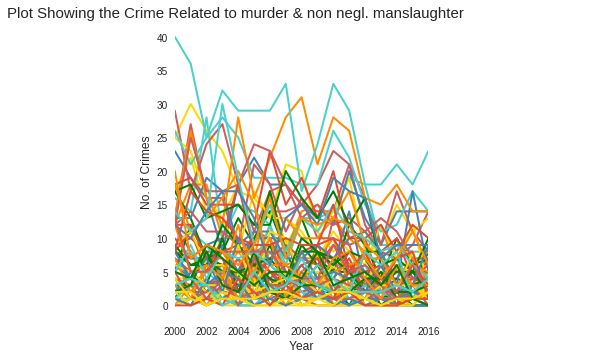

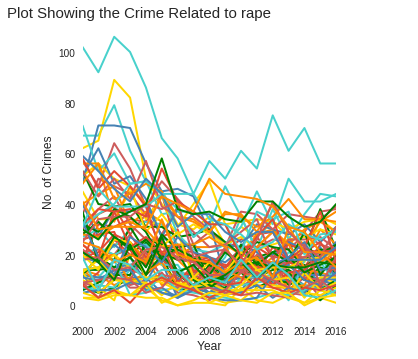

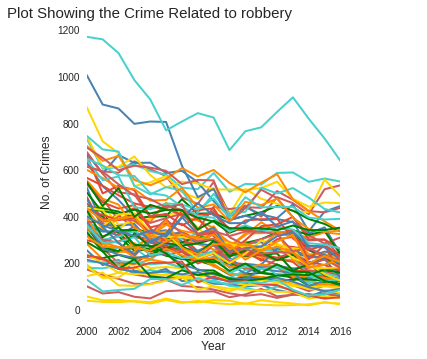

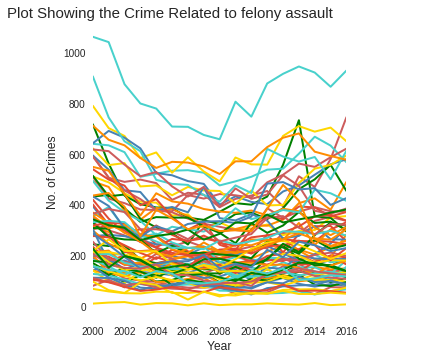

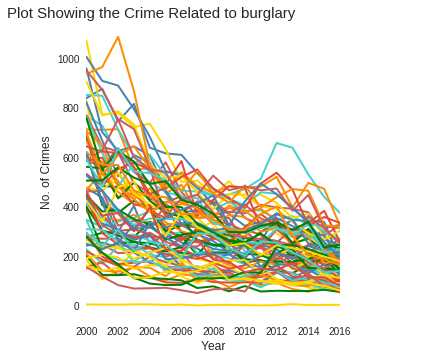

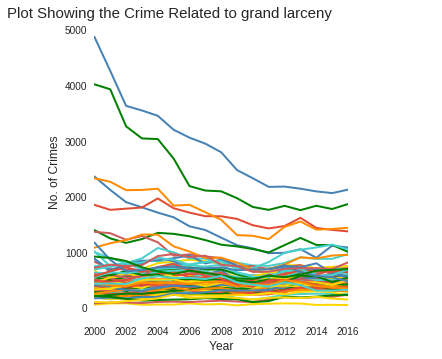

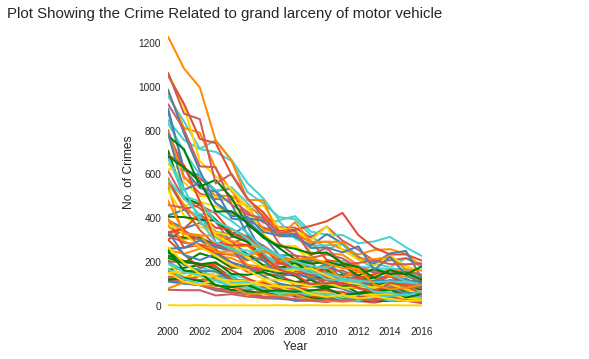

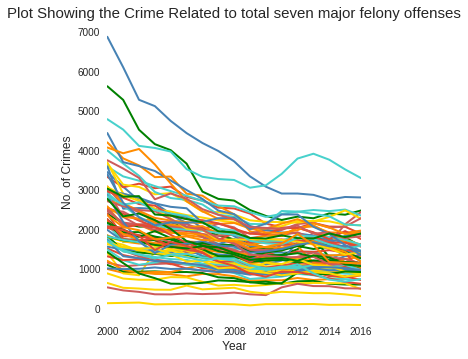

In [23]:
#Plotting the No. of Crimes for every type of Crime from year 2000 to 2016
for i in df_C.CRIME.unique():
    fig = pl.figure(figsize=(10,25))
    ax = fig.add_subplot(4,2,8)
    df_C[(df_C.CRIME == i)][year].T.plot(ax=ax, legend=False)
    ax.set_title("Plot Showing the Crime Related to " + i.lower(), fontsize=15)
    pl.ylabel("No. of Crimes", fontsize=12)
    pl.xlabel("Year", fontsize=12)

### Fig.1.3(a) : The Above plots shows the No. of Crimes carried out for a particular type of crime on a temporal frame.  It can be observed from the Visual analysis that the Hughest crime carried out were that of Grand Larceny, burglary, felany Assault and Robbery. These are petty cries and are common across the globe. One significant observation is that the overall crimes have reduced for most of the precints and this might be due to increased security measures adapted in the city after 9/11 2001 terror attacks.

# ----------------------------------x-----x-------x--------------------------------------------------------

# FBB caption and discussion ok, but there are other noticeable features and you plots presentation is poor,  your plots are not suitable for comparison because one has to scroll to see them so two plots cannot be compared if they are not nearby in the order
# task 1.3 8/10

## 1.4 calculate the mean and standard deviation in time for each precinct and each crime

In [24]:
df_C["mean"] = df_C.mean(axis=1)
df_C["stdev"] = df_C.std(axis=1)

#  FBB 2 mistakes: you are averaging over precinct number as well and in the stdev you are also averaging over the mean since you have now included it in the DF
# and you never even printed them!
# task 1/4 0/10

In [25]:
# I drop these values because this should not affect the clustering & Merging

In [26]:
df_C = df_C.drop(['mean','stdev'],axis=1)

In [27]:
df_C.columns

Index([  'PCT', 'CRIME',    2000,    2001,    2002,    2003,    2004,    2005,
        '2006',  '2007',  '2008',  '2009',    2010,  '2011',    2012,    2013,
          2014,    2015,    2016],
      dtype='object')

# ----------------------------------x-----x-------x--------------------------------------------------------

### EC1 - you can do a quantitative analysis of these time series (trends, periodicity etc.). But I recommend you only do it after you proceed to the other mandatory tasks. 

In [28]:
df_C.describe()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
count,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000
mean,607.407895,535.881579,509.240132,483.779605,467.411184,445.641447,423.296053,398.055921,388.013158,351.085526,345.773026,350.884868,366.736842,364.430921,346.480263,342.121711,329.842105
std,884.362126,790.138554,737.678203,698.458739,674.331052,633.547053,597.702894,564.973662,549.043166,499.551419,488.364400,494.834504,518.314802,520.220349,497.727100,491.234184,481.179329
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,57.750000,56.750000,52.500000,48.750000,49.000000,44.750000,38.000000,37.000000,33.750000,32.000000,31.000000,29.000000,30.000000,27.750000,29.000000,30.000000,28.750000
50%,338.000000,296.500000,287.500000,264.500000,260.500000,253.000000,232.500000,213.500000,208.500000,195.500000,183.000000,186.500000,185.000000,171.500000,165.000000,159.000000,141.000000
75%,645.000000,580.250000,559.500000,522.500000,493.000000,469.500000,456.500000,434.000000,429.750000,394.000000,394.500000,403.500000,431.000000,434.000000,412.750000,388.500000,384.750000
max,6857.000000,6088.000000,5265.000000,5105.000000,4730.000000,4423.000000,4173.000000,3971.000000,3708.000000,3330.000000,3103.000000,3393.000000,3780.000000,3902.000000,3751.000000,3506.000000,3287.000000


In [29]:
#To be Done

# ----------------------------------x-----x-------x--------------------------------------------------------

## 1.5 Extract the total crime row for each precinct and cluster the time series. Plot the clusters and discuss the clustering and the trends that you see. 
(as done in HW10 and 11, see [tips on clustering](https://github.com/fedhere/PUI2017_fb55/blob/master/final/preprocessinANDclustering.ipynb))
I am not looking for a particularly rigorous clustering analysis here, so you do not need to obsess over the right number of clusters for example, or the exact density for DBscan. However, once the clusters are done, visualize them, and make sure that they are convincing clusters that do display homogeneous trends that are different for the different clusters.

In [30]:
#Assigning a new Data Frame that contains the data of Total 7 Major felony in each Precint from 2000 to 2016
# Using K-Means mmode of clustering where clusters are gouped bsed on the closeness to the centroid.
df_Tot = df_C[df_C.CRIME ==  "TOTAL SEVEN MAJOR FELONY OFFENSES"]

In [31]:
# preprocessed by stadndardizing by row
# Ref: https://github.com/fedhere/PUI2017_fb55/blob/master/final/preprocessinANDclustering.ipynb
Xscaled = preprocessing.scale(df_Tot[year],axis=1)

# FBB PEP8 space after ,

In [32]:
df_Tot.columns

Index([  'PCT', 'CRIME',    2000,    2001,    2002,    2003,    2004,    2005,
        '2006',  '2007',  '2008',  '2009',    2010,  '2011',    2012,    2013,
          2014,    2015,    2016],
      dtype='object')

In [33]:
Xscaled.std(axis=1)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [34]:
# K-Means clustering: the essential parameter is the number of clusters.
Nc = 5
km = cluster.KMeans(n_clusters=Nc, random_state=123)
km.fit(Xscaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=123, tol=0.0001,
    verbose=0)

In [35]:
km.labels_

array([3, 1, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 1, 1, 3, 0, 3, 4, 3, 3, 3, 3, 4,
       2, 3, 3, 4, 3, 3, 4, 4, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 1,
       1, 1, 1, 1, 3, 1, 1, 3, 1, 3, 0, 2, 4, 1, 1, 3, 3, 4, 3, 3, 3, 3, 3,
       3, 1, 3, 3, 1, 3, 3], dtype=int32)

In [36]:
ccenter = km.cluster_centers_
ccenter

array([[ 0.98206706, -0.36159048, -0.25961739,  1.01897146,  0.93617022,
         0.77232423,  0.61584903,  0.0067275 , -0.03289237, -1.28168383,
        -1.16790403, -1.74970775, -0.20849325,  0.56750409,  0.07638679,
         0.36212397, -0.27623524],
       [ 2.45802457,  1.45392545,  1.08484814,  0.58751959,  0.3597    ,
         0.23583878, -0.02892719, -0.30844891, -0.4190353 , -0.9552954 ,
        -0.74215766, -0.53946201, -0.14474713, -0.26067738, -0.58720711,
        -0.85674088, -1.33715755],
       [ 1.77478236,  0.24471967, -0.0596111 , -0.49237251, -0.654315  ,
        -0.50913189, -0.72970485, -0.66548952, -0.51193033, -0.85255695,
        -0.88605647,  0.40105566,  1.31126215,  1.75243542,  0.42617579,
        -0.22995793, -0.3193045 ],
       [ 2.09819754,  1.38733218,  1.19783494,  0.92917936,  0.78210925,
         0.52658525,  0.25744849, -0.07433789, -0.22542912, -0.70416562,
        -0.81308824, -0.80674659, -0.73306533, -0.81814609, -0.98222747,
        -0.97953505

In [37]:
df_Tot["cluster"] = km.labels_

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [38]:
#This tells to which cluster the datapoint belongs to
df_Tot["cluster"]

7      3
15     1
23     3
31     3
39     3
47     0
55     3
63     3
71     3
79     3
87     3
95     3
103    1
111    1
119    3
127    0
135    3
143    4
151    3
159    3
167    3
175    3
183    4
191    2
199    3
207    3
215    4
223    3
231    3
239    4
      ..
375    1
383    1
391    1
399    1
407    3
415    1
423    1
431    3
439    1
447    3
455    0
463    2
471    4
479    1
487    1
495    3
503    3
511    4
519    3
527    3
535    3
543    3
551    3
559    3
567    1
575    3
583    3
591    1
607    3
615    3
Name: cluster, dtype: int32

In [39]:
df_Tot.head()

,PCT,CRIME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,cluster
7,1,TOTAL SEVEN MAJOR FELONY OFFENSES,3438.0,3069.0,2715.0,2649.0,2383.0,2305.0,2013.0,1914.0,1708.0,1578.0,1445.0,1402.0,1416.0,1416.0,1208.0,1446.0,1395.0,3
15,5,TOTAL SEVEN MAJOR FELONY OFFENSES,1780.0,1458.0,1309.0,1231.0,1170.0,1131.0,1040.0,1031.0,1029.0,975.0,969.0,962.0,1001.0,980.0,870.0,917.0,899.0,1
23,6,TOTAL SEVEN MAJOR FELONY OFFENSES,2387.0,2141.0,2059.0,2068.0,2174.0,2055.0,1979.0,1837.0,1738.0,1633.0,1530.0,1504.0,1574.0,1703.0,1575.0,1521.0,1388.0,3
31,7,TOTAL SEVEN MAJOR FELONY OFFENSES,990.0,892.0,908.0,864.0,857.0,804.0,864.0,856.0,807.0,702.0,702.0,704.0,762.0,711.0,732.0,781.0,823.0,3
39,9,TOTAL SEVEN MAJOR FELONY OFFENSES,2115.0,1672.0,1809.0,1801.0,1747.0,1664.0,1579.0,1519.0,1495.0,1523.0,1387.0,1350.0,1419.0,1424.0,1331.0,1337.0,1463.0,3


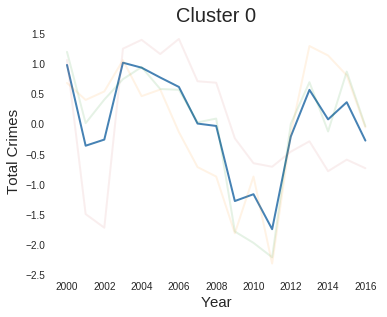

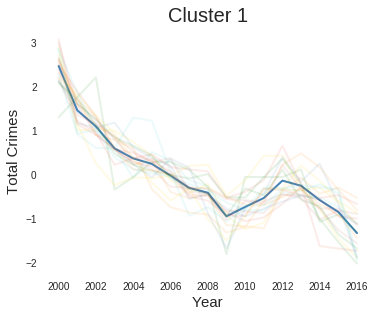

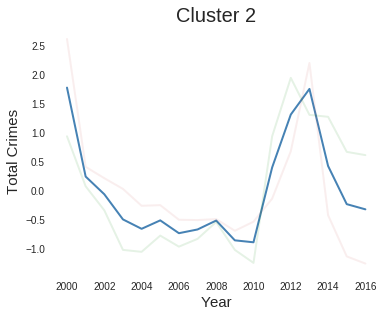

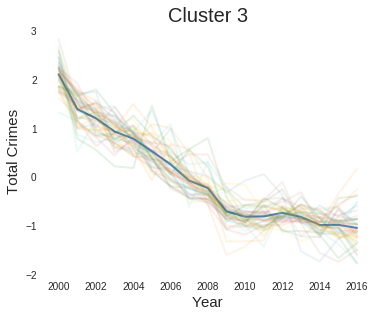

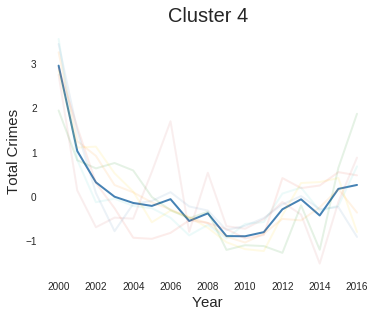

In [40]:
## Plotting the Clusters for the Total Crimes carried out per precinct
for i, cc in enumerate(ccenter):
    fig = pl.figure(figsize=(20,10))
    ax = fig.add_subplot(2,3,i+1)
    ax.plot(years, ccenter[i])
    for x in Xscaled[km.labels_ == i]:
        pl.plot(years, x, alpha = 0.1)
        pl.title("Cluster %d"%i, fontsize=20)
        pl.ylabel("Total Crimes", fontsize=15)
        pl.xlabel("Year", fontsize=15)  

### Fig.1.5(a) : This plot shows the Clustering of Total Crimes in New York City, precinct wise from year 2000 to 2016. 
#### The Cluster 0 shows a variable trend of Crime rate and is oscilatting over the selected temporal range. There is a steady drop in the Crime Rate in this cluster region from 2003 to 2011 and then there is an increase in crime rates until 2013 and there is a drop after that.
#### A lot of Precincts are closely oriented towards Cluster 1. There is a decrease in the crime rate in the observed period. It tends to go up from 2009 to 2012 but drops back again.
# FBB closely oriented? the cluster center is the mean of the cluster members. lots of precincts belong to cluster 2
#### In Cluster 2 the crime rate reduces intially and then starts increasing suddenly from 2010 to 2013 and then starts to decrease again. But the variation in Crime rate is very high from 2010 to 2015
#### Majority of the Precincts follow Cluster 3. It shows a steadily decreasing crime rate.
#### Cluster 4 has decreasing value of Crime rates until 2009 and then it starts increasing.

# FBB never discussed why 5 cluters, not before clustering and not after the fact adding a validation of the choice. are all the clusters sufficiently different to justify the choice? are the clusters compact?

# task 2.5 5/10

# ----------------------------------x-----x-------x--------------------------------------------------------

# ----------------------------------x-----x-------x--------------------------------------------------------

# ----------------------------------x-----x-------x--------------------------------------------------------

# Part 2: connecting the temporal and spatial components.
## 2.1 obtain the NYC precincts geometry and read it in as a shapefile 

### The data is available at [NYC Open Data Website->School,Police,Health & Fire->Police Precincts (Clipped to Shoreline)](http://www1.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page)

In [41]:
if(test==1):
    url1 = 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nypp_17d.zip'
    filename1 = 'nypp_17d.zip'
    filename2 = '/nypp_17d/nypp.shp'
    os.system('wget ' + url1)
    os.system('unzip ' + filename1)
    os.system('mv ' + filename2 + PUIdata)

# FBB same error! PUIdata needs a space before the first character but also you need all the other files to read the shapefile! so you cannot read the shapefile with what you moved to PUIdata

In [42]:
# Loading NYC Precints Data as a Geopandas Data Frame
nyc_P = gpd.GeoDataFrame.from_file(PUIdata + "/nypp_17d/nypp.shp")

In [43]:
nyc_P

,Precinct,Shape_Leng,Shape_Area,geometry
0,1,80586.154615,4.730176e+07,(POLYGON ((972081.7882080078 190733.4674072266...
1,5,18676.124259,1.808880e+07,"POLYGON ((987399.2067871094 202660.9920043945,..."
2,6,27182.610113,2.213193e+07,"POLYGON ((984337.591796875 208351.1055908203, ..."
3,7,17301.308682,1.836402e+07,"POLYGON ((991608.6323852539 201215.2305908203,..."
4,9,19773.233410,2.139423e+07,"POLYGON ((992119.1235961914 204042.7609863281,..."
5,10,40043.175251,2.722863e+07,"POLYGON ((983866.0408325195 217203.5975952148,..."
6,13,27719.171669,2.950889e+07,"POLYGON ((989359.7009887695 210293.3984375, 98..."
7,14,20974.709243,2.051016e+07,"POLYGON ((991274.0015869141 213749.6546020508,..."
8,17,26622.002811,2.226969e+07,(POLYGON ((994166.3048095703 211286.7564086914...
9,18,42179.905777,3.228033e+07,"POLYGON ((985929.4006347656 220967.1235961914,..."


# task 2.1 0 (two reasons why reading the file as you have it here does not work)/

# ----------------------------------x-----x-------x--------------------------------------------------------

## 2.2 merge the precincts geodataframe with the dataframe of crime that you used to cluster the time series and plot a choropleth of the clusters. 
Discuss if you see spatial coherence - does the geographical information help interpret the trends you see in time domain?

In [44]:
#Merging the Total Crimes per Precint from 2000 to 2016 to the NYC Precint Shape File
nyc_Ptot = nyc_P.merge(df_Tot, left_on="Precinct", right_on="PCT")

In [45]:
nyc_Ptot.head()

,Precinct,Shape_Leng,Shape_Area,geometry,PCT,CRIME,2000,2001,2002,2003,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,cluster
0,1,80586.154615,4.730176e+07,(POLYGON ((972081.7882080078 190733.4674072266...,1,TOTAL SEVEN MAJOR FELONY OFFENSES,3438.0,3069.0,2715.0,2649.0,...,1708.0,1578.0,1445.0,1402.0,1416.0,1416.0,1208.0,1446.0,1395.0,3
1,5,18676.124259,1.808880e+07,"POLYGON ((987399.2067871094 202660.9920043945,...",5,TOTAL SEVEN MAJOR FELONY OFFENSES,1780.0,1458.0,1309.0,1231.0,...,1029.0,975.0,969.0,962.0,1001.0,980.0,870.0,917.0,899.0,1
2,6,27182.610113,2.213193e+07,"POLYGON ((984337.591796875 208351.1055908203, ...",6,TOTAL SEVEN MAJOR FELONY OFFENSES,2387.0,2141.0,2059.0,2068.0,...,1738.0,1633.0,1530.0,1504.0,1574.0,1703.0,1575.0,1521.0,1388.0,3
3,7,17301.308682,1.836402e+07,"POLYGON ((991608.6323852539 201215.2305908203,...",7,TOTAL SEVEN MAJOR FELONY OFFENSES,990.0,892.0,908.0,864.0,...,807.0,702.0,702.0,704.0,762.0,711.0,732.0,781.0,823.0,3
4,9,19773.233410,2.139423e+07,"POLYGON ((992119.1235961914 204042.7609863281,...",9,TOTAL SEVEN MAJOR FELONY OFFENSES,2115.0,1672.0,1809.0,1801.0,...,1495.0,1523.0,1387.0,1350.0,1419.0,1424.0,1331.0,1337.0,1463.0,3


In [46]:
cp.choroplethNYC?

(<matplotlib.figure.Figure at 0x7fb9e0469e10>,
 <matplotlib.colorbar.Colorbar at 0x7fb9ddd517f0>)

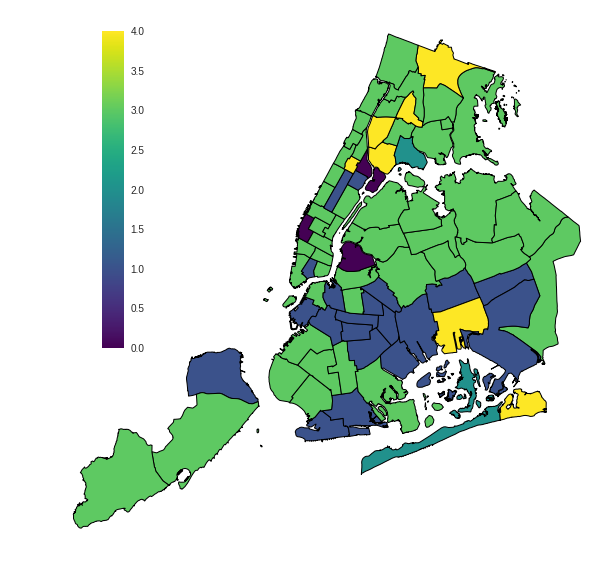

In [47]:
#Visulaizing the Clusters on a geographic map using the choropleth
cp.choroplethNYC(nyc_Ptot, column="cluster", edgecolor="black")

### Fig.2.2(a): This plot shows the overall crime trends geographically represented on a NYC Precinct Map Clustered  based on the time series. It is observed that most of the regions follow cluster 3 that denotes decreasing rates of crimes in NYC. The Region that runs between Brooklyn and Queens(The Blue Patch) follows Cluster 0 that has a up and down oscillating crime trend, but has been in the decrease since 2013. One Precint on the Upper East Side and a few precints near Coney Island follow cluster 2 where crime rates where initially decreasing and then went up and started decreasing again within a short time spectrum. A Few Precincts in Midtown Manhattan and a Precinct in Downtown Manhattan follow Cluster 1 that also decreases->increase and then decrease again in the crime rates. Only a few Precincts in Bronx and one Precinct each in Queens and Coney Island follow Cluster 4 and have an increasing trend of Crime rates. So it is of atmost imoportance that the security measures are tighened in this region.

# FBB this is not the place for policy recommandations! this is just an expliratory analysis and conclusions should hardly be made. things that it is fair to point out: geographical cohesion across BK and Man, different trends in isolated area in Rockaway (airport) and BX

# FBB wrong axis in the colorbar. the option discrette creates a discrete colorbar

# FBB 7/10

# ----------------------------------x-----x-------x--------------------------------------------------------

### EC2 visualize each crime by precinct. here you can choose the visual display that you prefer, but not a time series plot (like you did before) or a coropleth (like you will do later). It could be a box and whiskers plot for example

In [48]:
df_C.CRIME.unique()


array(['MURDER & NON NEGL. MANSLAUGHTER                                ',
       'RAPE                                  ',
       'ROBBERY                               ',
       'FELONY ASSAULT                        ',
       'BURGLARY                              ',
       'GRAND LARCENY                         ',
       'GRAND LARCENY OF MOTOR VEHICLE                                  ',
       'TOTAL SEVEN MAJOR FELONY OFFENSES'], dtype=object)

In [49]:
# Each Crime By Precinct
for i in df_C.CRIME.unique():
    crimeprecint = nyc_P.merge(df_C[df_C.CRIME == i], left_on="Precinct", right_on="PCT")

In [50]:
 crimeprecint.columns

Index([  'Precinct', 'Shape_Leng', 'Shape_Area',   'geometry',        'PCT',
            'CRIME',         2000,         2001,         2002,         2003,
               2004,         2005,       '2006',       '2007',       '2008',
             '2009',         2010,       '2011',         2012,         2013,
               2014,         2015,         2016],
      dtype='object')

# ----------------------------------x-----x-------x--------------------------------------------------------

## 2.3 download the data containing the socioeconomic features to be used as exogenous variables. 
I prepared a file with socioeconomic features for each precinct: unemployed fraction, median income, fraction of the precinct area that is green. Dowload it from https://nyu.carto.com via sql (HW 7) ( ideally only extracting the relevant columns). The source sql is  'https://fb55.carto.com:443/api/v2/sql?q=' , the name of the file  *nycsocioeconomicsbyprecinct*


In [51]:
# Choosing only the required attributes from the Database 
# precinct, green, medianincome, unemployment
query = '''SELECT precinct,green,medianincome,unemployment FROM fb55.nycsocioeconomicsbyprecinct'''
seco = pd.read_csv(StringIO(queryCartoDB(query)), sep=',')

In [52]:
seco.head()

,precinct,green,medianincome,unemployment
0,1,0.058702,124092.068749,0.021444
1,60,0.173512,35015.008703,0.056448
2,61,0.238375,65998.923662,0.055458
3,63,0.158530,33655.205265,0.031215
4,24,0.166040,113966.467973,0.043461


# FBB 2.3 10/10

# ----------------------------------x-----x-------x--------------------------------------------------------

## 2.4 *pivot* the crime dataframe so that you have a dataframe with precinct on the index and each crime type on the columns 
This task may be the most unfamiliar. look at the hints for an example on how to do it. If this fails you can download the pivoted file [here](https://github.com/fedhere/PUI2017_fb55/blob/master/final/crimepivoted.csv)

In [53]:
#!wget https://raw.githubusercontent.com/fedhere/PUI2017_fb55/master/final/crimepivoted.csv

In [54]:
#crime_P= pd.read_csv("crimepivoted.csv")

In [55]:
df_C.pivot?

#######  Pivot: when you want to create a dataframe with felonies on the columns, instead of the rows. The easiest way to do it is to “pivot” the dataframe you have. This is the only needed function we never used it in a homework. Use the .pivot method of a dataframe 
df.pivot(index=..., columns=...)
Pass it the name of the column you want as index (I suggest the precinct column) and the columns you want as row index (i suggest the crime names) and extract the featueres you desire (the column you created with the mean, e.g. crime[‘crimemean’])


In [56]:
df_C["mean"] = df_C.mean(axis=1)
df_C["stdev"] = df_C.std(axis=1)

# FBB still wrong as before

In [57]:
#Pivot
crime_P=df_C[["PCT", "CRIME", "mean"]].pivot(index="PCT",columns="CRIME")["mean"]

In [58]:
crime_P.columns

Index(['BURGLARY                              ',
       'FELONY ASSAULT                        ',
       'GRAND LARCENY                         ',
       'GRAND LARCENY OF MOTOR VEHICLE                                  ',
       'MURDER & NON NEGL. MANSLAUGHTER                                ',
       'RAPE                                  ',
       'ROBBERY                               ',
       'TOTAL SEVEN MAJOR FELONY OFFENSES'],
      dtype='object', name='CRIME')

# ----------------------------------x-----x-------x--------------------------------------------------------

## 2.5 merge the dataframe with the socioeconomic data with the pivoted crime data,  and merge the precinct geodataframe with it. plot a choropleth of each of the 7 felonies, plus the total crime by precinct
clean up your data so that the only columns left are the 7 felonies, the total number of felonies, and the socioeconomic features (unemployment, median income, park access). I recommend you rename the crime features: the dataframes have very annoying white spaces encoded in them. See the hints file to remove them.

In [59]:
#Cleaning the Data

In [60]:
nyc_Ptot.columns

Index([  'Precinct', 'Shape_Leng', 'Shape_Area',   'geometry',        'PCT',
            'CRIME',         2000,         2001,         2002,         2003,
               2004,         2005,       '2006',       '2007',       '2008',
             '2009',         2010,       '2011',         2012,         2013,
               2014,         2015,         2016,    'cluster'],
      dtype='object')

In [61]:
crime_P.columns

Index(['BURGLARY                              ',
       'FELONY ASSAULT                        ',
       'GRAND LARCENY                         ',
       'GRAND LARCENY OF MOTOR VEHICLE                                  ',
       'MURDER & NON NEGL. MANSLAUGHTER                                ',
       'RAPE                                  ',
       'ROBBERY                               ',
       'TOTAL SEVEN MAJOR FELONY OFFENSES'],
      dtype='object', name='CRIME')

In [62]:
nyc_temp = nyc_Ptot.merge(crime_P, left_on="Precinct", right_index=True)

In [63]:
nyc_All = nyc_temp.merge(seco, left_on = "Precinct", right_on = "precinct")

 The names of each crime in the crime dataset are poorly formatted: there are white spaces at the end of the names. To remove the white spaces remember that dataframes have a method rename() which takes a dictionary:

          cols = {“oldName1”: “newName1”,
	          “oldName2”: “newName2”}
          df.rename(columns=cols)



one can use a for loop iterating over each column name to create the dictionary usng the string method replace:

for c in columnNames:
	cols[c] = c.replace(“ “,””)

The years are also poorly formatted: some read as int some as strings


In [64]:
#Function to Clean the data
def clear(cols):
    for i in nyc_All.columns:
        if not isinstance(i, int):
            cols[i] = i.replace(" ", "") 
            

# FBB ok, you are getting me confused at thit point but it all seems to work

In [65]:
cols = {}
clear(cols)

In [66]:
nyc_All.rename(columns=cols, inplace=True)

In [67]:
nyc_All.head()

,Precinct,Shape_Leng,Shape_Area,geometry,PCT,CRIME,2000,2001,2002,2003,...,GRANDLARCENY,GRANDLARCENYOFMOTORVEHICLE,MURDER&NONNEGL.MANSLAUGHTER,RAPE,ROBBERY,TOTALSEVENMAJORFELONYOFFENSES,precinct,green,medianincome,unemployment
0,1,80586.154615,4.730176e+07,(POLYGON ((972081.7882080078 190733.4674072266...,1,TOTAL SEVEN MAJOR FELONY OFFENSES,3438.0,3069.0,2715.0,2649.0,...,1406.705882,81.470588,1.058824,8.588235,125.705882,1970.588235,1,0.058702,124092.068749,0.021444
1,5,18676.124259,1.808880e+07,"POLYGON ((987399.2067871094 202660.9920043945,...",5,TOTAL SEVEN MAJOR FELONY OFFENSES,1780.0,1458.0,1309.0,1231.0,...,616.823529,45.882353,1.882353,7.529412,147.058824,1103.058824,5,0.049462,99148.860914,0.046260
2,6,27182.610113,2.213193e+07,"POLYGON ((984337.591796875 208351.1055908203, ...",6,TOTAL SEVEN MAJOR FELONY OFFENSES,2387.0,2141.0,2059.0,2068.0,...,1183.000000,82.117647,1.294118,9.470588,199.823529,1815.647059,6,0.035655,119565.099444,0.029992
3,7,17301.308682,1.836402e+07,"POLYGON ((991608.6323852539 201215.2305908203,...",7,TOTAL SEVEN MAJOR FELONY OFFENSES,990.0,892.0,908.0,864.0,...,317.352941,74.117647,2.588235,10.705882,172.000000,809.352941,7,0.125848,44645.989878,0.052540
4,9,19773.233410,2.139423e+07,"POLYGON ((992119.1235961914 204042.7609863281,...",9,TOTAL SEVEN MAJOR FELONY OFFENSES,2115.0,1672.0,1809.0,1801.0,...,833.176471,89.529412,2.294118,15.470588,208.764706,1566.764706,9,0.080894,82391.812180,0.041264


In [68]:
nyc_All = nyc_All.drop(['PCT','precinct'],axis=1)

In [69]:
nyc_All.columns

Index([                     'Precinct',                    'Shape_Leng',
                          'Shape_Area',                      'geometry',
                               'CRIME',                            2000,
                                  2001,                            2002,
                                  2003,                            2004,
                                  2005,                          '2006',
                                '2007',                          '2008',
                                '2009',                            2010,
                                '2011',                            2012,
                                  2013,                            2014,
                                  2015,                            2016,
                             'cluster',                      'BURGLARY',
                       'FELONYASSAULT',                  'GRANDLARCENY',
          'GRANDLARCENYOFMOTORVEHICLE',   'MURDER&N

# FBB your df by now should only have one value, the mean that you calculatted, for each precinct for every crime, and the socioeconomic data. you should drop all the years, and the crime column which makes no sense because you should have a single row for every precinct. I gave you a dataframe to check yours against.

# task 2.4 10 - the pivot, but this DF will get you in trouble Im sure. (I cantt tell if you have 1 time series for each crime or only for tot crime)

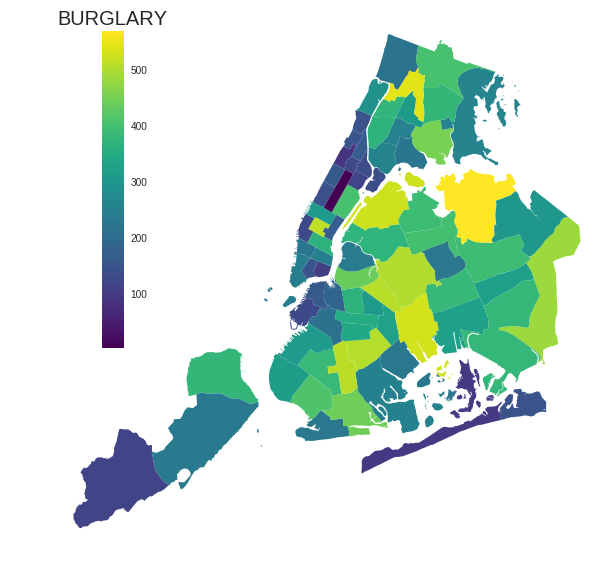

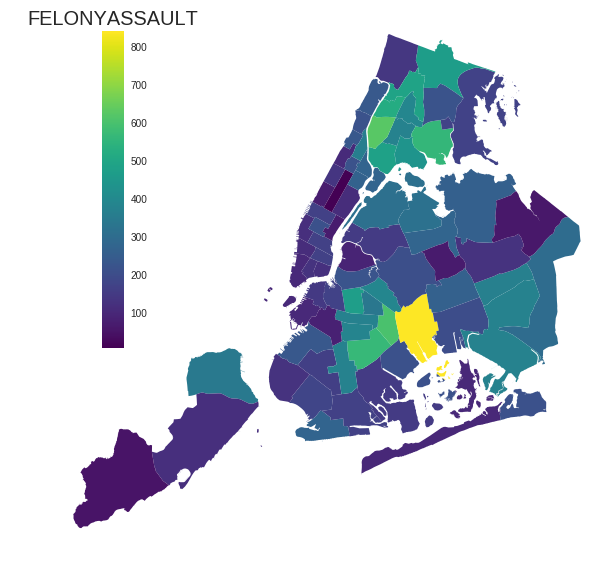

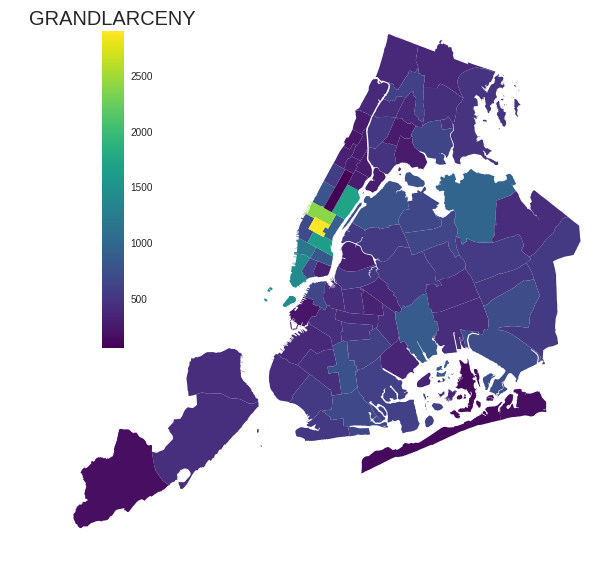

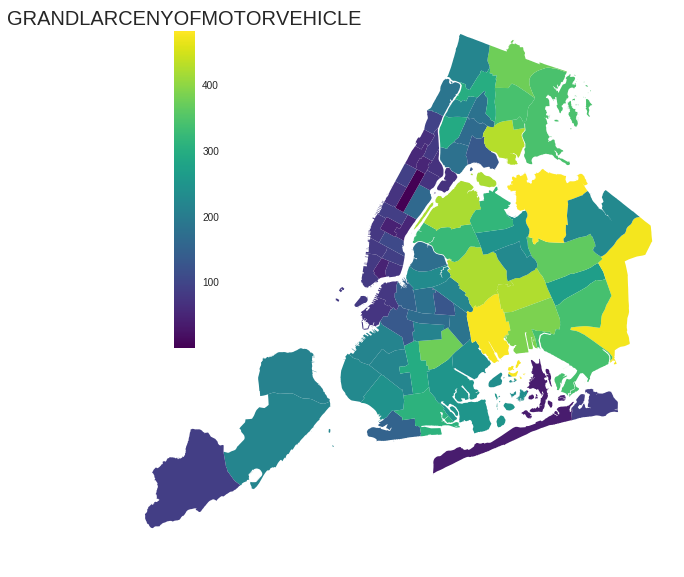

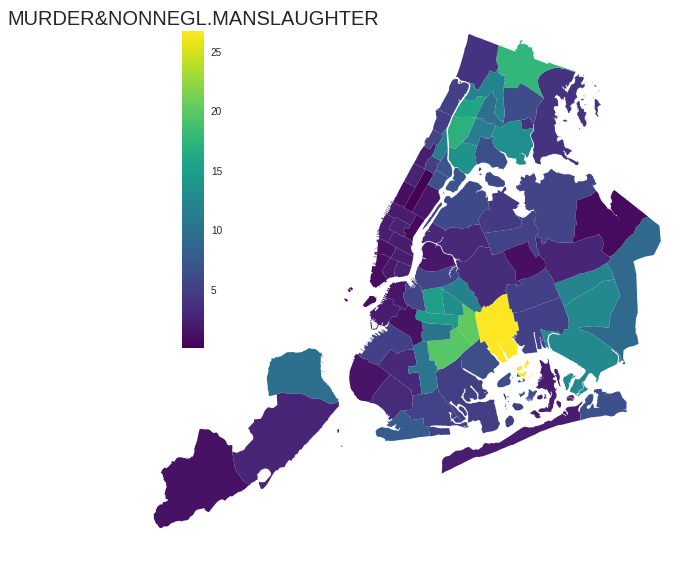

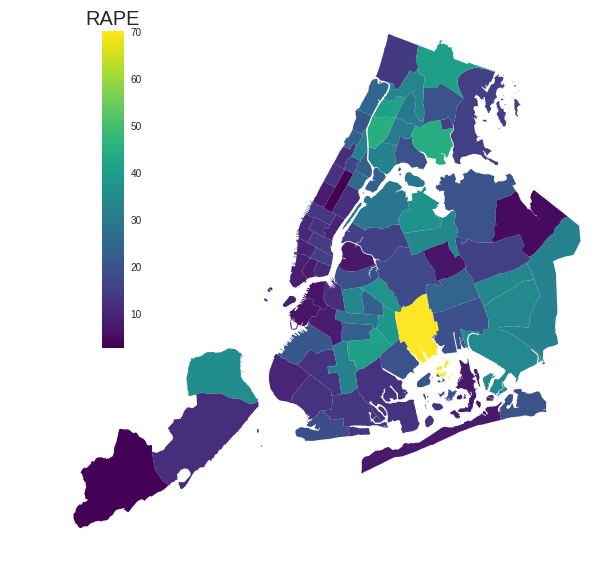

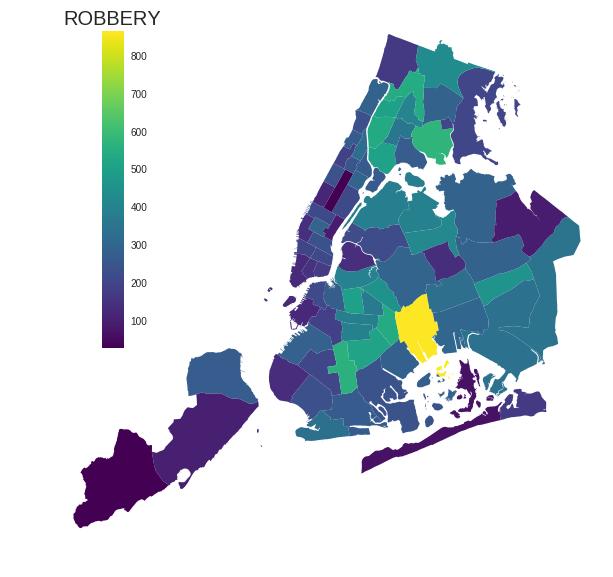

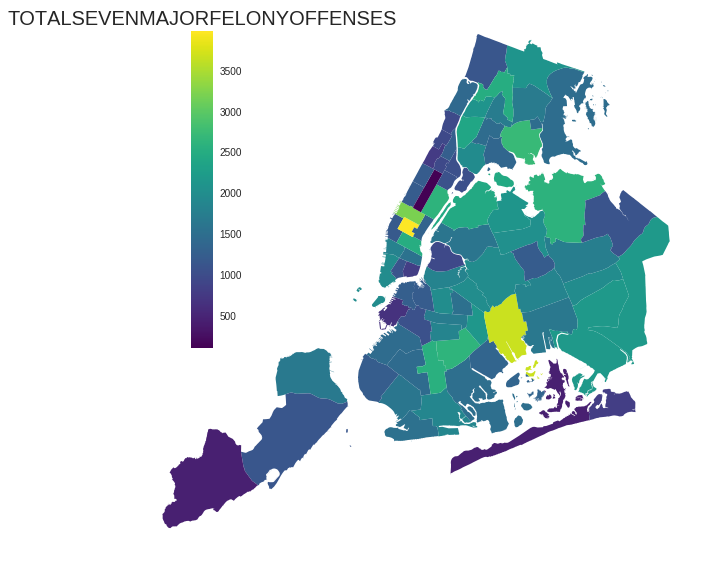

In [70]:
for c in [u'BURGLARY', u'FELONYASSAULT', u'GRANDLARCENY', 
          u'GRANDLARCENYOFMOTORVEHICLE', 
          u'MURDER&NONNEGL.MANSLAUGHTER',u'RAPE', 
          u'ROBBERY', u'TOTALSEVENMAJORFELONYOFFENSES']:
    cp.choroplethNYC(nyc_All, column=c)
    pl.title(c.upper(), fontsize = 20)
    pl.show()

## Used this map for [NYC Boroughs Map](https://nycmap360.com/nyc-boroughs-map#.WjaSbd-nE2w)
## Fig.2.5(a) : This Figure Shows the distribution of induvidual crime scene types across New York City.
#### 1. Burglary: The Burglary rates are high in northern queens as we enter into NYC and at few central locations of Brroklyn such as Crown Heights. It is Surprising to see that the Burglary rates are low at Coney Island and near Central Park.
#### 2. Felony Assault: In Contrast to Burglary the Felony Assault rates are low as we enter NYC via Queens. The Felony Assualt rates looks very high in East New York region of Brooklyn.
#### 3. Grand Larceny: This type of crime is high in Midtown where the buildings are densely located and a lot of Commercial and Tourist activity takes place. Often there are cases of ATM Snatching, Taking away public property etc.
#### 4. Grand Larceny of Motor Vehicles : It is interesting to see that this map is a contrast of the Grand Larcenary Map. Most of the cases are recorded in Queens region that has a comparitively higher no. of people parking cars on road.
#### 5. Murder & Man Slaughter: The rates are very high in East New York. They are also relatively higher in Bronx and Upper Brroklyn. They are almost negligible in Manhattan.
#### 6. Rape: High Values in East New York and Bronx. 
#### 7. Robbery: Once again, higher values in East New York. It is intruiging to notice that the rates of Burglary is high in upper queens and Robbery is very low there.

### Overall, It looks like the East New York region might be the most riskiest place in NYC. The Midtown area also has higher crime rate but that is mainly due to Grand Larceny. It is surprising that Redhook has lower crime rates and there are vey low crime rates in Coney Island and Centra park region. This might be due to the fact that there are not many inhabitants who live there. But this might be evident from further deep analysis that might be beyond the scope of this project. From the Map, we couls say Lower Staten Island, Coney Island and Central Park region may be safest areas of NYC.

# FBB Careful! these numbers are not per person! so they should not be considered as comparable in the sense of what is the riskiest or less risky place in NYC the only comparison that is allowed at this stage is between the relative numbers of felonies: which place has high rape vs larcey ration, murder vs robbery etc.

# FBB like before the figures are hard to compare cause they are one below the other and large enought that no more than one can be sen at a time 

# task 2.5 2/10

# ----------------------------------x-----x-------x--------------------------------------------------------

## 2.6 cluster the data first using the socioeconomic features and then using the 7 felonies 
You can use a simple Euclidean distance, since these are all numerical features, which is the default for most packages, or define your distance. if you do that, which would be exciting, please justify your distance definition. Mind the preprocessing! Do the clusters make sense?, is the grouping preserved? are the outliers outliers in both clustering schemes?

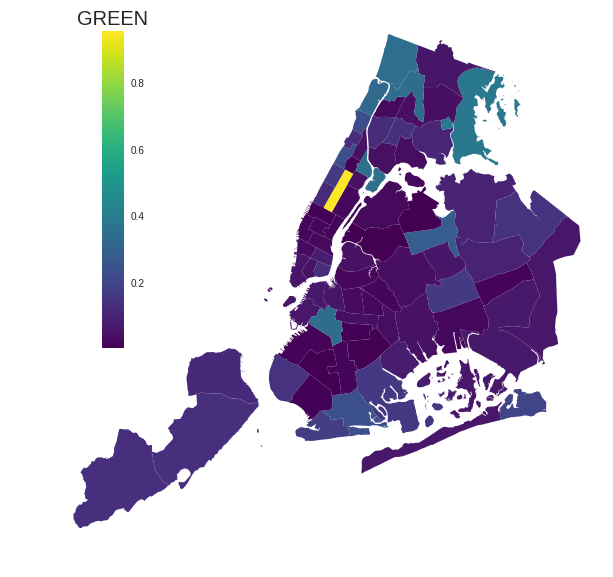

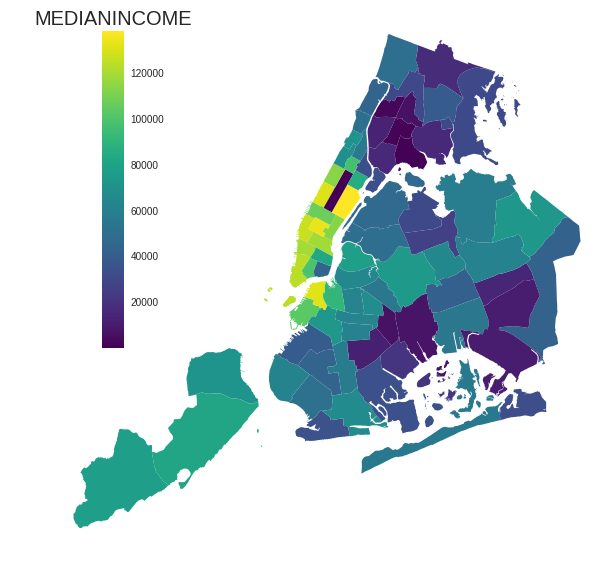

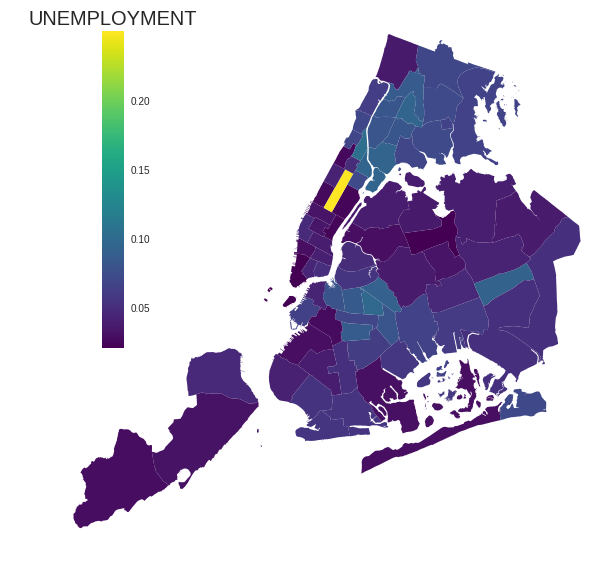

In [71]:
# Plot of Socio-Economic Parameters in New York City: We plot this to see if the Correlation Holds Good After Grouping
for c in [u'green', u'medianincome', u'unemployment']:
    cp.choroplethNYC(nyc_All, column=c)
    pl.title(c.upper(), fontsize = 20)
    pl.show()

## Fig.2.6(a) : This Figure Shows the distribution of Greenness, Median Income & Unemployment across New York City.
#### 1. Greenness: The Greenness values are high in the regions where there are huge open spaces such as parks. The greenness values are high in Central Park, Prospect park and a few other localities in the northern region of Bronx. It is understood explicitly that the green cover is much lesser near the Central Business District in Midtown/Downtown Manhattan and regions close to them. However it is very surprising that there is much less green cover in lower Staten Island 
#### 2. Mediian Income: The Median Income is clearly high in the Borough of Manhattan. Upper East Side and Midtown/Downtown Manhattan especially are on the higher side odf income. Bronx and East New Yok have very low median income.
#### 3. Unemployment: Unemployment is high in the regions of Bronx and the boundary between Queens and Brooklyn. Central Park data could be neglected as no one lives there.


# FBB ok

In [72]:
#A Numpy Array that contains the Sociecnomical Attributes of NYC
X_Socio = preprocessing.scale(nyc_All[[u'green', u'medianincome', u'unemployment']])

In [73]:
#A Numpy Array that contains the Crime Data of NYC
X_Crime = preprocessing.scale(nyc_All[[u'BURGLARY', u'FELONYASSAULT', u'GRANDLARCENY', 
                                       u'GRANDLARCENYOFMOTORVEHICLE',u'MURDER&NONNEGL.MANSLAUGHTER',
                                       u'RAPE', u'ROBBERY',]])

In [74]:
# K-Means clustering: Clustering the Socio-Economic Parameters 
#By Default Euclidean Distance is considered u K-Means
Nc = 5
km_Socio = cluster.KMeans(n_clusters=Nc, random_state=123)
km_Socio.fit(X_Socio)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=123, tol=0.0001,
    verbose=0)

In [75]:
# K-Means clustering: Clustering the Crime Data Parameters
Nc = 5
km_Crime = cluster.KMeans(n_clusters=Nc, random_state=123)
km_Crime.fit(X_Crime)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=123, tol=0.0001,
    verbose=0)

In [76]:
#Utilising DB_Scan: USing points separated no greater than eps 
#DB_Socio = cluster.DBSCAN(eps=0.5,min_samples=5, metric='euclidean').fit(X_Socio)
#DB_Crime = cluster.DBSCAN(eps=1,min_samples=2, metric='euclidean').fit(X_Crime)


In [77]:
#Creating two new Columns that store the Cluster Details
nyc_All["socio_C"] = km_Socio.labels_
nyc_All["crime_C"] = km_Crime.labels_

In [78]:
#Centers of the Clusters
ccenter_Socio = km_Socio.cluster_centers_
ccenter_Crime = km_Crime.cluster_centers_

## Clustering Socio-Economic Data

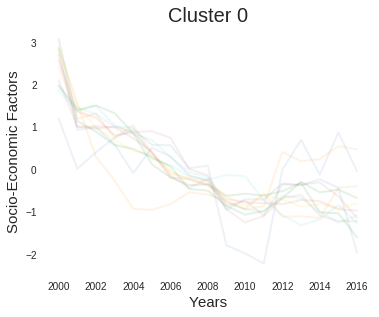

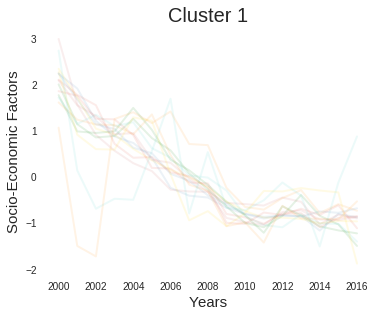

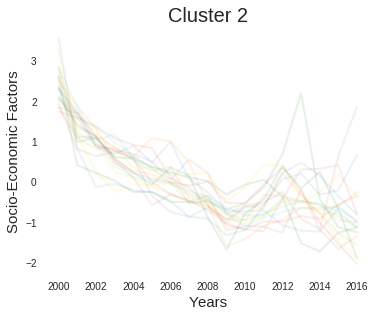

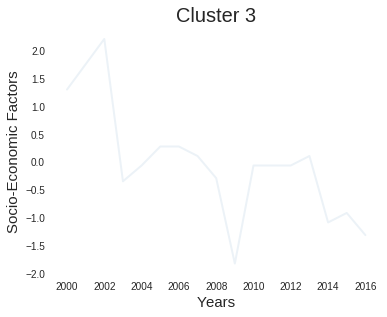

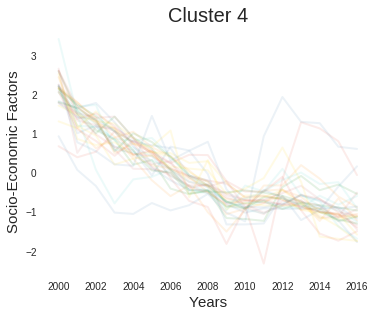

In [79]:
## Plotting the Clusters for Socio-Economic Data
for i, cc in enumerate(ccenter_Socio):
    fig = pl.figure(figsize=(20,10))
    ax = fig.add_subplot(2,3,i+1)
    for x in Xscaled[km_Socio.labels_ == i]:
        pl.plot(years, x, alpha = 0.1)
        pl.title("Cluster %d"%i, fontsize=20)
        pl.ylabel("Socio-Economic Factors", fontsize=15)
        pl.xlabel("Years", fontsize=15)

## Fig.2.6(b). This Figure describes the Clustering of Socio-Economic Attributes in the City from 2000 to 2016

# FBB not really: they describe the crime time evolution by precint for precincts clustered by socioeconomic features. At this point I think you are getting confused

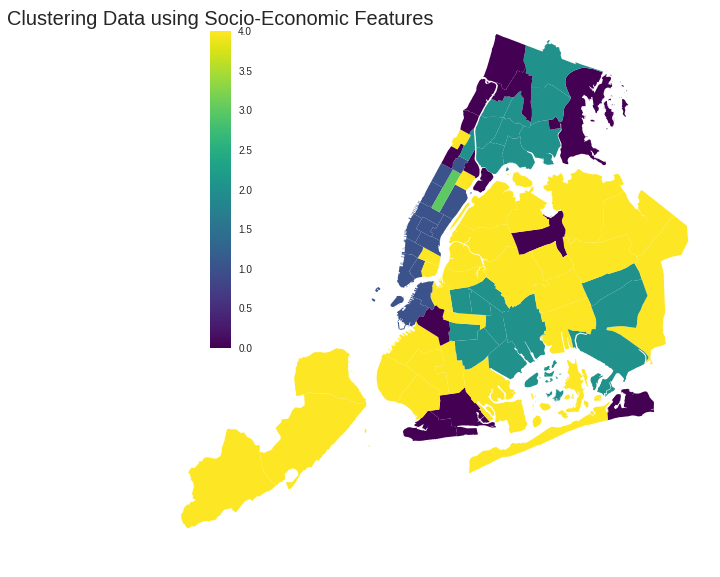

In [80]:
cp.choroplethNYC(nyc_All, column="socio_C")
pl.title("Clustering Data using Socio-Economic Features", fontsize = 20)
pl.show()

## Fig.2.6(c). This Figure describes the Clustering of Socio-Economic Attributes in the City from 2000 to 2016, Geographically.  All the Clusters show a decreasing trend, let us see the clustering in detail below:

### Cluster-0: This region has low unemployment, below average Median Income and Average Greenness Factor. This is mostly observed in upper Bronx and scattered in one or two regions in the other Borough
### Cluster-1: This Region has very Low Unemployment, High Median Income and Low Greenness Factor.This is mostly observed in Midtown/Downtown Manhattan that houses most of the Business District.
### Cluster-2: This cluster is for the regions in Bronx and a few precincts in Brooklyn and Queens. This area has low green, average unemployment and low Median Income.
### Cluster-3: This is Central Park data that has almoset sero median income, highest unemployment and highest greenness factor.
### Cluster-4: This is cluster where most of Queens, Brooklyn and the whole of Staten island falls into. They have High Unemployment, Above Average Income and low Green Cover

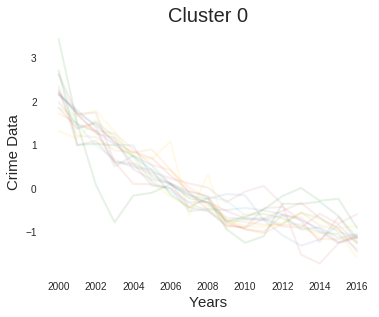

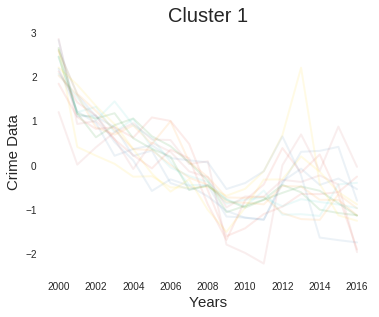

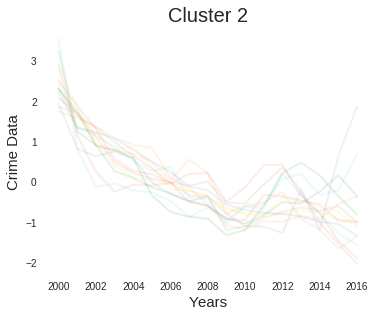

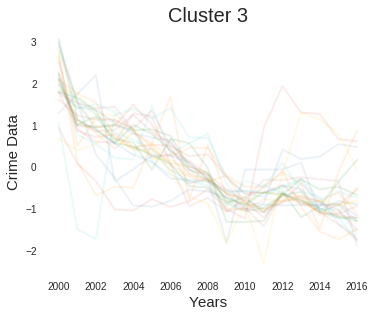

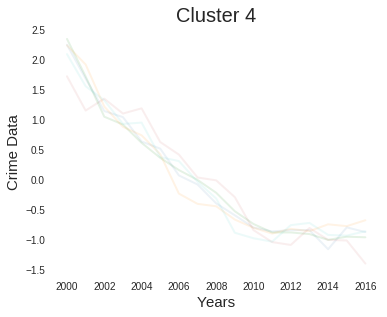

In [81]:
## Plotting the Clusters for the Crime Data by Type
for i, cc in enumerate(ccenter_Crime):
    fig = pl.figure(figsize=(20,10))
    ax = fig.add_subplot(2,3,i+1)
    for x in Xscaled[km_Crime.labels_ == i]:
        pl.plot(years, x, alpha = 0.1)
        pl.title("Cluster %d"%i, fontsize=20)
        pl.ylabel("Crime Data", fontsize=15)
        pl.xlabel("Years", fontsize=15)


## Fig.2.6(d):This Figure describes the Clustering of Type of Crime data in the City from 2000 to 2016

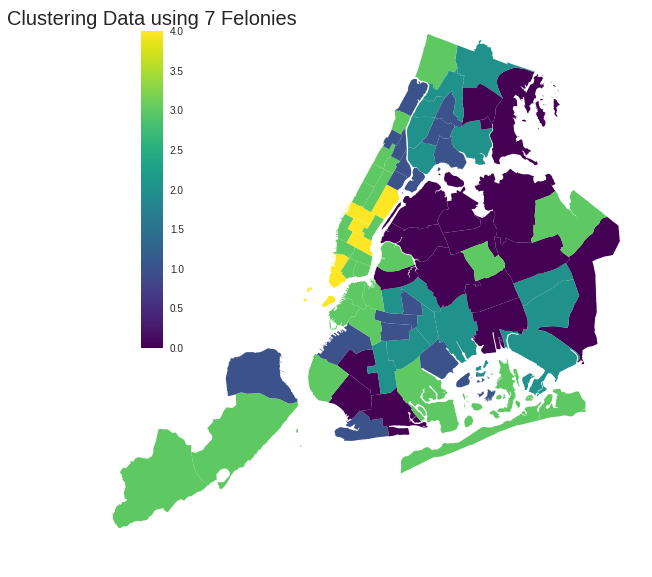

In [82]:
cp.choroplethNYC(nyc_All, column="crime_C")
pl.title("Clustering Data using 7 Felonies", fontsize = 20)
pl.show()

## Fig.2.6(e). This Figure describes the Clustering of of Type of Crime data in the City from 2000 to 2016, Geographically.  

### A Very clear Downward trend can be observed in all the plots. This indicates that there is a drop in the overall Crime rates in New York City. 
 


# FBB again: these clusters have nothing to do with crime. here the discussion should have been: are precincts with similar socioeconomic features also similar in crime metrics?

# task 2/10 the whitening and clustering was allright, except for the missing discussion of the choice of number of clusters, but the interpretation is very confusing and actually. you are no longer clustering on time!

# ----------------------------------x-----x-------x--------------------------------------------------------

## 2.7 At last, create a function that for a target variable input generates a model based on median income (medianincome), green area (green), and unemployed fraction (unemployment), and returns some parameter of model quality and the most important feature in the model. The function should also print or otherwise report whether the feature is statistically significant. Run this function four times to predict BURGLARY, RAPE, MURDER, and TOTAL CRIME

I want this to be a function:

        def fitCrime(...):
            ...
            return importance,quality
    
You can run the function with all the precincts, or with the clusters you created above, but discuss the pros and cons of each scheme. You can use any model. I am ok with multi linear regression, but consider other options: trees, SVM, whatever you have explored in PUI, in other classes, in the EC project. I am not looking for a rigorous assessment. If you use statsmodels for regression you can pull any of the diagnostics in the model.summary() (any of the *appropriate* ones). If you use a machine learning method you can assess via cross validation, seeing how much the score changes between test and training sample. Keep in mind that am definitely more interested in the discussion than in the creation of a "good" model. 

**Discuss explicitly which features are important to predict what** 

## Function Fitcrime1 uses **Random Forest** which is an ensmeble machine learning based classification/regression model that constructs a large no. of decision trees during training phase and outputs the class that is the mode of all class(Classification) and/or the Mean(Regression) of induvidual trees

# PEP8 missing docstring

In [83]:
def fitCrime1(crime):
    yaxis = preprocessing.scale(nyc_All[[crime]])
    X_Socio.std(axis=0)
    crimeFeatures = ensemble.RandomForestRegressor().fit(X_Socio, yaxis)
    #print (crimeFeatures.feature_importances_)
    return crimeFeatures.feature_importances_, crimeFeatures.score(X_Socio, yaxis)

### Feature_importances_ : returns the feature importances 
#### The higher, the more important the feature


### Score Function returns the coefficient of determination R^2 of the prediction.

The coefficient R^2 is defined as (1 - u/v), where u is the regression
sum of squares ((y_true - y_pred) ** 2).sum() and v is the residual
sum of squares ((y_true - y_true.mean()) ** 2).sum().
Best possible score is 1.0 and it can be negative (because the
model can be arbitrarily worse). A constant model that always
predicts the expected value of y, disregarding the input features,
would get a R^2 score of 0.

## Function Fitcrime2 uses **OLS** which is a linear statistical regression Model that jsimply takes ordinary least squares

In [84]:
nyc_All['Murder'] = nyc_All[u'MURDER&NONNEGL.MANSLAUGHTER']

In [85]:
model_params = [u'green',  u'medianincome',  u'unemployment',
              u'BURGLARY', u'FELONYASSAULT', u'GRANDLARCENY', 
              u'GRANDLARCENYOFMOTORVEHICLE', u'Murder',
              u'RAPE',  u'ROBBERY', u'TOTALSEVENMAJORFELONYOFFENSES']

def fitCrime2(crime):
    smod_C = smf.ols(formula = crime + '~ green + medianincome + unemployment', 
                 data=nyc_All[model_params]).fit()
    return smod_C.summary()
    return smod_C


# FBB this is returning everything though!

### smod_C.summary Summarizes the Regression Results


In [86]:
print (fitCrime1(u'TOTALSEVENMAJORFELONYOFFENSES'))
print (fitCrime1(u'BURGLARY'))
print (fitCrime1(u'RAPE'))
print (fitCrime1(u'Murder'))

(array([ 0.33173829,  0.46251751,  0.2057442 ]), 0.87264327514566298)
(array([ 0.32998353,  0.3695689 ,  0.30044756]), 0.87076820915581543)
(array([ 0.16259703,  0.5817018 ,  0.25570117]), 0.87366572339974458)
(array([ 0.09295515,  0.49266592,  0.41437893]), 0.9160140780762499)


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel

# FBB with random forest you need to do cross validation to assess model performace

In [87]:
print (fitCrime2(u'TOTALSEVENMAJORFELONYOFFENSES'))
print (fitCrime2(u'BURGLARY'))
print (fitCrime2(u'RAPE'))
print (fitCrime2(u'Murder'))

                                  OLS Regression Results                                 
Dep. Variable:     TOTALSEVENMAJORFELONYOFFENSES   R-squared:                       0.165
Model:                                       OLS   Adj. R-squared:                  0.130
Method:                            Least Squares   F-statistic:                     4.733
Date:                           Sun, 17 Dec 2017   Prob (F-statistic):            0.00454
Time:                                   23:48:22   Log-Likelihood:                -597.99
No. Observations:                             76   AIC:                             1204.
Df Residuals:                                 72   BIC:                             1213.
Df Model:                                      3                                         
Covariance Type:                       nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------

## Discussion on Modelling
### The objective is to generate a model for a particular Crime Type based on  green area (green), median income (medianincome) and unemployed fraction (unemployment), and return model quality and the most important feature in the model. 
### Here in this excercise we have implemented two different types of models i. Random Forest ii. OLS to see which one models better. 
### Random Forest an ensmeble machine learning based classification/regression model that constructs a large no. of decision trees during training phase and outputs the class that is the mode of all class(Classification) and/or the Mean(Regression) of induvidual trees is used in case 1.
### This Model has yielded excellent results and have excellent model scores meaning that this model would predict a highly accurate result. The Scores for TOTAL SEVEN MAJOR FELONY OFFENSES , BURGLARY. RAPE & Murder are as below Repectively:

## Crime Type	               Score	        The Most Important Features		

### Total Seven Major Felony:
### Score =  0.845564415; This is a very good score and the quality of the model is very good.

### The Most Important Features: 	0.36966623,	0.43914585,	0.19118792 - In this case  highest weightage is given to Green Area, followed by Median Income and then Unemployment rate. Therefore we can conclude that Overall Crime rate is more sensitive to Median Income > Green Areas > Unemployment Fraction.

## Similarly we can see that the score of all the models are very good and the models would have a much better prediction capability.

### Burglary:
### Score = 0.82448125; 
### The Most Important Features: 	0.31773872,	0.37523222,	0.30702906 
### Median Income > Green Areas > Unemployment Fraction.

## Rape: 
### Score = 0.892783038; 
### The Most Important Features: 	0.14025253,	0.65540172,	0.20434574
### Median Income > Unemployment Fraction > Green Areas 

## Murder: 
### Score =  0.91222324; 
### The Most Important Features: 	0.14659946,	0.35900803,	0.49439251
### Unemployment Fraction > Green Areas > Median Income

# Second Method Fitcrime2 uses OLS which is a linear statistical regression Model that simply takes ordinary least squares

### This Model has yielded not so great results as the R-Squared values are very low. he Scores for TOTAL SEVEN MAJOR FELONY OFFENSES , BURGLARY. RAPE & Murder are as below Repectively:

### Total Seven Major Felony:
### R-squared:                       0.165



### Burglary:
### R-squared:                       0.224


## Rape: 
### R-squared:                       0.516


## Murder: 
### R-squared:                       0.573

### Since the R-Squared values are very less, we will not discuss much about this model as Random Forest has produced much better results. However this could be improved if we try Multi Regression or any other effective Machine Learning Model

# FBB but you only assessed the in-sample performance, so the model may severly overfit the data
# task 2.7 10

## Conclusion: 

### This Analysis carried out to study the New York City Crime rate yielded excellent results. It was evident from the analysis that the Crime Data and the Socio-Economic data exhibit a relationship and we were succesful in clustering NYC based on the Crime and Socio-Economic Data. We also carried out a Temporal analysis that helped us to understand the trend of Crimes(including type) that take place in NYC and this could help us to understand how secure we are today compared to past 15 years.  The Clustering of Time series helped us understand different trends that popped up based on crime type and it was surprising to see increasing crime rate trends too.

### Combining the Crime data with the precinct data helped us take the visualise the data on a Geographical Co-Ordinate. With this we were able to understand the most safest and riskiest neighborhood in NYC and the types of crimes that take place in different neighborhood. Analysing this in Temporal frame showed us how every induvidual precinct have performed on the safety values and how the crime rates(also for a particular type of crime) has infcreased or decreased over a period of time. 

# FBB avoid statements about safety based on non-normalized quantities - crime rates are not comparable if they are not per person (avoid double superlatives in english most safest -> most safe)
### Combining this data with the Socio-Economic Attributes of Greenness, Median Incom aand Unemployment Fraction rate have taken this analysis to the next level. We were able to understand how Socio-Economic Factors vary over the city and how this relates to the Crime Data.

### Finally modelling the Crime Data based on the Socio-Economic parameters gave a completeness to the project.

###  The next Steps of this data we could try and relate the 311 Complaints and see if we are able to see if there is a correlation with that to the crime rate. 

# in the first part the thing to compare was the crime evolution: which precincts have similar crime ttrends in time
# in the second part the thing to compare is the crime rations for each precinct, and the relation between crime and socioeconomics: do the same socioeconomic environments lead to similar crime characteristics?


## Glossary:
### df_C : Data Frame that contains all the Crimes Listed Precinct-Wise from year 2000 to 2016
### df_Tot: Data Frame that contains the data of Total 7 Major felony in each Precinct from 2000 to 2016
### nyc_P : Data Frame that contains the Geographical Coordinates and Shape and Area of Each Precinct
### nyc_Ptot : Data frame that contains the data of Total 7 Major felony in each Precinct from 2000 to 2016 along with the Geographical Coordinates and Shape and Area of Each Precinct.
### Seco: Dataframe containing Socioeconomic parameters such as precinct, green, median income, unemployment
### nyc_All: Dataframe that contains data of all 7 crimes and Socioeconomic data



# Extra Credit 

I decided to add this as the conversation kept getting pushed toward details of spatial joins during the final reviews. If this all was easy, recreate the percentage of green area in a precinct, the unemployment rate by precinct, and the median income by precinct.

you will need:
a shapefile for the NYC parks which you can access from the https://data.cityofnewyork.us/. With the overlay function get the area of the green spaces contained in a precinct. 
I only selectted the following park subcategories. 

selectedParks = ['Community Park', 'Recreation Field/Courts', 'Triangle/Plaza',
       'Garden', 'Neighborhood Park', 'Nature Area', 'Waterfront Facility',
       'Historic House Park', 'Playground', 
       'Flagship Park', 
       'Jointly Operated Playground', 'Managed Sites']


A census tract shapefile is also accessible through the NYC open data portal or http://www1.nyc.gov/site/planning/data-maps/open-data.page
    
Overlay the census tract and precinct geometries (geopandas.overlay) to get the fraction of each tract in a precinct. This will allow you to create a weighted average of the unemployment percentage and median income.

You will need tree features from the American Community Survey which you can find on American Fact Finder.   
If, as they should, these are accessed through the API your API link should begin with https://api.census.gov/ (e.g. [5 year ACS](https://www.census.gov/data/developers/data-sets/acs-5year.html))

- the 2015  5 year ACS survey unemployment data by census tract (the total number of individuals is available through the API at the census tract geometry aggregation level. 

- the 2015  5 year ACS survey total count of people by census tract (to generate the unemployment percentage).

- the 2015  5 year ACS survey median income by census tract.

Some precinct geometries will fail, and likely will report that the operation is not doable with MultiPolygons. These operations are actually doable with MultyPolygons, but some of the precincts have non valid geometries. For those you can use the convex hull (pctshp.geometry.map(lambda x: x.convex_hull)) to get the intersection, with some loss (is the loss in accuracy or precision?)

## Results Produced using the Carto Database downloaded from Dr.Federica Bianco
## Similar Results to be simulated using the 
### 1. NYC Parks Dataset
### 2. NYC Census Tract Dataset
### 3. NYC ACS Data :
- the 2015  5 year ACS survey unemployment data by census tract (the total number of individuals is available through the API at the census tract geometry aggregation level. 

- the 2015  5 year ACS survey total count of people by census tract (to generate the unemployment percentage).

- the 2015  5 year ACS survey median income by census tract.


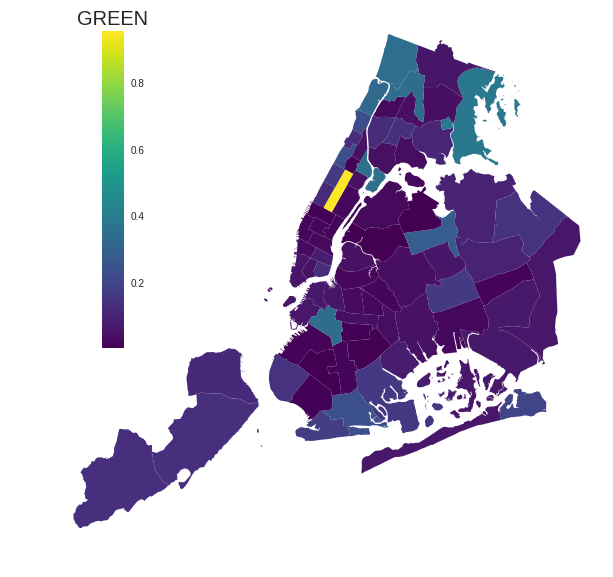

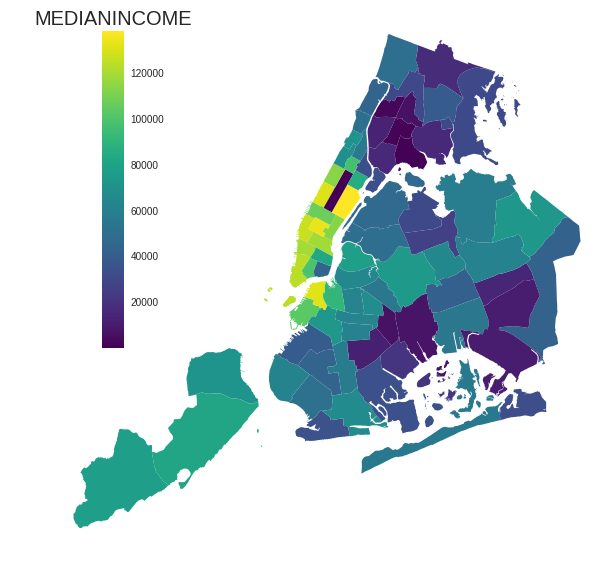

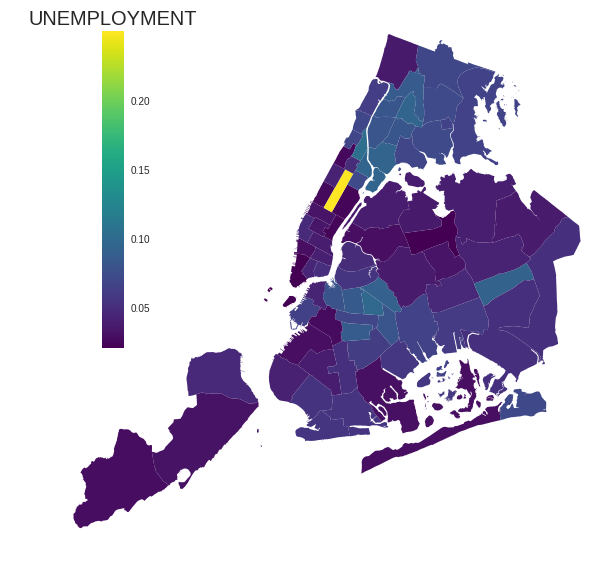

In [88]:
for c in [u'green', u'medianincome', u'unemployment']:
    cp.choroplethNYC(nyc_All, column=c)
    pl.title(c.upper(), fontsize = 20)
    pl.show()

In [89]:
if (test==1):
    url1a = 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nypp_17c.zip'
    filename1a = 'nypp_17c.zip'
    filename2a = '/nypp_17c/nypp.shp'
    os.system('wget ' + url1a)
    os.system('unzip ' + filename1a)
    os.system('mv ' + filename2a + PUIdata)

In [90]:
if (test==1):
    url1a = 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyct2010_17c.zip'
    filename1a = 'nyct2010_17c.zip'
    filename2a = '/nyct2010_17c/nyct2010.shp'
    os.system('wget ' + url1a)
    os.system('unzip ' + filename1a)
    os.system('mv ' + filename2a + PUIdata)

In [91]:
#Loading the NYC Census Tract File from  http://www1.nyc.gov/site/planning/data-maps/open-data.page
nyc_CT = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/nyct2010_17c/nyct2010.shp")

In [92]:
# Re-Reading the Precinct Data File
nyc_PT = gpd.GeoDataFrame.from_file(PUIdata + "/nypp_17c/nypp.shp")

In [93]:
#This converts to convex_hull where acuracy is lost
nyc_CT[nyc_CT.geometry.type == 'MultiPolygon'].geometry = \
    nyc_CT[nyc_CT.geometry.type =='MultiPolygon'].geometry.map(lambda x: x.convex_hull)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  frame[geo_column_name] = level


In [94]:
nyc_CTPT = gpd.overlay(nyc_CT, nyc_PT, how = 'intersection')

Too few points in geometry component at or near point 1013377.9022216797 149419.95678710938
Too few points in geometry component at or near point 1013272.7846069336 149426.54699707031
Too few points in geometry component at or near point 1013415.5244140625 149422.59283447266
Too few points in geometry component at or near point 1013452.8668212891 149427.84698486328
Too few points in geometry component at or near point 1013489.750793457 149435.69360351562
Too few points in geometry component at or near point 1013525.9852294922 149446.09020996094
Too few points in geometry component at or near point 1013561.4104003906 149458.99041748047
Too few points in geometry component at or near point 1013595.9694213867 149474.38842773438
Too few points in geometry component at or near point 1013986.4956054688 149616.43139648438
Too few points in geometry component at or near point 1014157.3392333984 149657.69903564453
Too few points in geometry component at or near point 1014179.3692016602 149665.1

AttributeError: 'MultiPolygon' object has no attribute 'exterior'

Alothough the error is reported as being due to MultiPolygon it is in fact due to invalid geometries. At the top of my head the  35th  and 72nd precincts in the file fail and were the only 2 needing convex haull, regardless of being multipolygons or not (the second one was not I think)

## Got an Error and did not know how to proceed further. Was Stuck in here for a very very long time

In [95]:
url1b = 'https://raw.githubusercontent.com/praveenashokkumar/gittest_pak348/master/Parks%20Properties.geojson'
os.system('mv ' + '/Parks%20Properties.geojson' + PUIdata)

256

In [96]:
parks = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/Parks Properties.geojson")

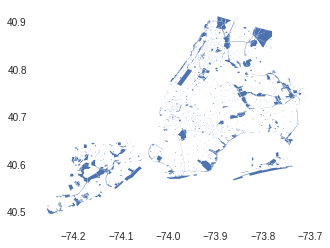

In [97]:
parks.plot()

## Could not do the remaining Extra Credit as I got stuck on a merge error. I am curious to know how to solve it, as I never could do it.

# FBB you surely could! give yourself time to absorbe all you have learned this semester and more time to figure it out I will release a solution

# FBB there are some very good things, and a good attempt to make observations, but there are some significant mistakes as well and a tendency for OVER interpretation, in this case even to make policy recommandation, which is definitely incorrect and not supported by your analysis (or in general by the scope of the analysis in this exercise which is exploratory and comparative)

# because your crime numbers are not per person (or statistics such as means and medians) you cannot directly compare precincts to se which is more or less dangerous! 

# in the first part the thing to compare was the crime evolution: which precincts have similar crime trends in time

# in the second part the thing to compare is the crime ratios for each precinct (e.g. rape/murder etc), and the relation between crime and socioeconomics: do the same socioeconomic environments lead to similar crime characteristics?


task 1.1 8: there are silly mistakes in the syntax. but how did ut work for you w those mistakes?? or did you modify the cells after reading locally?

task 1.2 10


task 1.4 8 (meager discussion and poor figure organization)

task 1.4 0 

task 1.5 5 (no discussion of cluster number choice)

task 2.1 0 two mistakes in reading and moving file

task 2.2 7 - issues w interpretation

task 2.3 10

task 2.4 10

task 2.5 2

task 2.6 2

task 2.7 10

EC good try

some PEP 8 violations but will not have points deducted, since you tried the EC

# 72/100